In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess

root = "/scratch/project_465000467/FABIO/Anesthetics/PartitionCoef"

In [ ]:
#make water box
def make_water_box(root):
    source = f"/scratch/project_465000467/FABIO/modules.sh"
    subprocess.call(f"source {source}; cd {root};"+
                    f"mkdir start_files; cd start_files;"+
                    f"cp scratch/project_465000467/FABIO/Anesthetics/scripts/SW.gro .; cp scratch/project_465000467/FABIO/Anesthetics/scripts/TW.gro .; cp scratch/project_465000467/FABIO/Anesthetics/scripts/W.gro .;"+
                    f"gmx insert-molecules -ci W.gro -o water_box.gro -nmol 400 -scale 1 -box 5.5 5.5 5.5;"+
                    f"gmx insert-molecules -f water_box.gro -ci SW.gro -o water_box.gro -nmol 400 -scale 1 -box 5.5 5.5 5.5;"+
                    f"gmx insert-molecules -f water_box.gro -ci TW.gro -o water_box.gro -nmol 400 -scale 1 -box 5.5 5.5 5.5;", executable="/bin/bash", shell=True)

#solvate
def solvate(root,mol,solv,maxsolv):
    source = f"/scratch/project_465000467/FABIO/modules.sh"
    subprocess.call(f"source {source}; cd {root};"+
                f"gmx solvate -cp {mol}.gro -cs solvent.gro -o solvated.gro -box 5.5 5.5 5.5 -maxsol {maxsolv[solv]};",
                executable="/bin/bash", shell=True)

#minimize
def minimize(root,molname):
    source = f"/scratch/project_465000467/FABIO/modules.sh"
    subprocess.call(f"source {source}; cd {root};"+
                f"gmx grompp -f run_min.mdp -c solvated.gro -p {molname}.top -maxwarn 2;"+
                f"gmx mdrun -v -c {molname}.gro",
                executable="/bin/bash", shell=True)

In [ ]:
source = f"/scratch/project_465000467/FABIO/modules.sh"

mol = "Diethyl_ether"
molname = "ETH"
solv = "oil_solvation"
maxsolv = {"water_solvation":1200,"oil_solvation":320}
path = f"{root}/{mol}/{solv}"

#solvate(path,mol,solv,maxsolv[solv])
#minimize(path,molname)

Text(0.5, 0, 'Molecule')

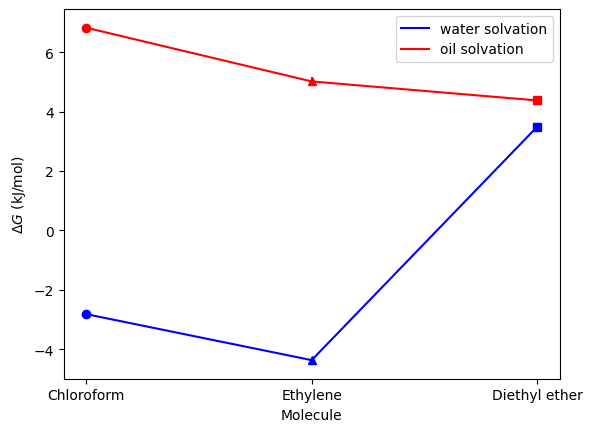

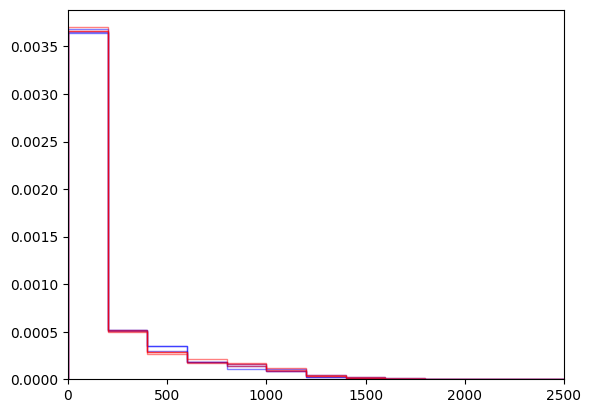

In [7]:
mols = ["Chloroform","Ethylene","Diethyl_ether"]
solvs = ["water_solvation","oil_solvation"]
colors = {"water_solvation":"blue","oil_solvation":"red"}
markers = {"Chloroform":"o","Ethylene":"^","Diethyl_ether":"s"}

fig, ax = plt.subplots()
fig1, ax1 = plt.subplots()

for solv in solvs:

    line_x = []
    line_y = []
    for mol in mols:
        path = f"{root}/{mol}/{solv}/production"
        df = pd.read_csv(f"{path}/final.dat", sep="\s+", header=None)
        hist = pd.read_csv(f"{path}/histogram.xvg", sep="\s+", header=None, skiprows=156)
        dG = df.loc[:,5].values[0]
        err = df.loc[:,7].values[0]

        ax.errorbar(mol.replace("_"," "), dG, err, marker=markers[mol], color=colors[solv])
        ax1.hist(hist.loc[:,1].values, bins=100, histtype="step", density=True, alpha=0.5, color=colors[solv])
        line_x.append(mol.replace("_"," "))
        line_y.append(dG)
    ax.plot(line_x, line_y, color=colors[solv], label=solv.replace("_"," "))

ax1.set_xlim(0,2500)
ax.legend()
ax.set_ylabel(r"$\Delta G$ (kJ/mol)")
ax.set_xlabel("Molecule")